In [2]:
import os
import ase
import torch
import glob
import math
from copy import deepcopy
from tqdm import tqdm
import numpy as np
from ase.io import Trajectory
from ase.visualize import view
import nglview as nv
import ipywidgets
from ase.neighborlist import natural_cutoffs, NeighborList
from fairchem.core.datasets import LmdbDataset
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pylab as pylab
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scienceplots
from math import floor, log10
from matplotlib import rc
from mace.calculators import mace_off
plt.style.use(['science','no-latex'])

params = {'figure.dpi': 900,
            'axes.labelsize': 'small',
          'legend.fontsize': 'x-small',
         'axes.titlesize':'medium',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'font.family': 'DejaVu Sans'}

pylab.rcParams.update(params)

CYAN = "#00FFFF"

ORANGE = '#ffad33'
PINK = "#FF81C0"
MAGENTA = "#FF00FF"
YELLOW = "#FAC205"
SILVER = "#C5C9C7"
GRAY = "#929591"
DARK_GRAY = "#5b5b5b"
BLUE = "#069AF3"
DARK_BLUE = "#0000FF"
RBLUE = "#0088cc"
RPURPLE = "#5c12de"
RYELLOW = "#dead12"

data_dir = "/data/shared/ishan_stuff/md22/lmdb"
checkpoint_dir = "/data/shared/ishan_stuff"

# nv.show_asetraj(traj)


In [3]:
# Adapted from https://github.com/kyonofx/MDsim/blob/main/observable.ipynb

def distance_pbc(x0, x1, lattices):
    delta = torch.abs(x0 - x1)
    lattices = lattices.view(-1,1,3)
    delta = torch.where(delta > 0.5 * lattices, delta - lattices, delta)
    return torch.sqrt((delta ** 2).sum(dim=-1))

def dir_to_legend_name_and_color(md_dir):
    name = ""
    color_list = [ORANGE, RBLUE, ORANGE, RBLUE, DARK_GRAY]
    if "gemT" in md_dir:
        name += "GemNet-T - Gradient-Based Forces"
        idx = 0
    elif "gem" in md_dir:
        name += "GemNet-dT - Direct Forces"
        idx = 2
    elif "jmp" in md_dir:
        name += "JMP-L - Direct Forces (Teacher)"
        idx = 4
    
    if "undistilled" in md_dir.lower():
        name += ", Undistilled"
    elif "distilled" in md_dir.lower():
        name += ", Distilled"
        idx +=1

    return name, color_list[idx]

def get_thermo(filename):
    """
    read thermo logs.
    """
    with open(filename, 'r') as f:
        thermo = f.read().splitlines()
        sim_time, Et, Ep, Ek, T = [], [], [], [], []
        for i in range(1, len(thermo)):
            try:
                t, Etot, Epot, Ekin, Temp = [float(x) for x in thermo[i].split(' ') if x]
                sim_time.append(t)
                Et.append(Etot)
                Ep.append(Epot)
                Ek.append(Ekin)
                T.append(Temp)
            except:
                sim_time, Et, Ep, Ek, T = [], [], [], [], []
    thermo = {
        'time': sim_time,
        'Et': Et,
        'Ep': Ep,
        'Ek': Ek,
        'T': T
    }
    return thermo
    
def plot_stability(data_split, checkpoint_dir, md_dirs, append_name = ""):
    if append_name != "":
        append_name = "_" + append_name
    # First figure: Bond length deviation over time
    plt.figure()

    # Remove axis ticks from the top and right borders
    plt.tick_params(top = False)
    plt.tick_params(right = False)

    # Reduce font size of the axis number labels (tick labels)
    plt.tick_params(axis='both', which='major', labelsize=10)  # Adjust size as needed

    
    plt.xlabel("Simulation time (ps)", fontsize=10)
    plt.xlim(0, 105)
    plt.ylabel("Max bond length deviation (A)", fontsize=10)
    plt.yscale('log')
    plt.axhline(stability_threshold, linestyle="dashed", c='r', label="Stability Threshold")
    
    

    # teacher_calc = mace_off(model="large", dispersion=False, default_dtype="float32", device='cuda')

    # Prepare lists to hold ref energies for the second figure
    all_ref_energies = []
    all_energies = []
    labels = []
    colors=  []

    # Set up the OCP calculator
    checkpoint_path = os.path.join(config["MODELPATH"], config["run_name"], "best_checkpoint.pt")
    calc = OCPCalculator(
        config_yml=args.config_yml.__str__(),
        checkpoint_path=checkpoint_path,
        cpu=False,
        seed=args.seed,
    )

    for md_dir in md_dirs:

        # load all system trajectories and logs for this model
        trajectories = glob.glob(os.path.join(checkpoint_dir, md_dir, "*.traj"))
        logs = glob.glob(os.path.join(checkpoint_dir, md_dir, "*.log"))
        ref_energies = []

        for j, (traj, log) in enumerate(zip(trajectories, logs)):
            traj = Trajectory(traj)
            # get bonds from simulated trajectory
            atoms = traj[0]
            NL = NeighborList(natural_cutoffs(deepcopy(atoms)), self_interaction=False)
            NL.update(atoms)
            bonds = NL.get_connectivity_matrix().todense().nonzero()
            bonds = torch.tensor(bonds)

            # get bonds from GT trajectory
            data = LmdbDataset({"src": os.path.join(data_dir, data_split, "train")})
            gt_traj = []
            
                
            for idx in range(len(data)):
                dat = data.__getitem__(idx)
                if "md22" not in md_dir:
                    if dat.atomic_numbers.shape[0] == atoms.numbers.shape[0]:
                        if np.equal(np.array(dat.atomic_numbers), atoms.numbers).all():
                            gt_traj.append(dat.pos)
                else:
                    gt_traj.append(dat.pos) # all md22 data for a given molecule has the same number of atoms

            gt_traj = torch.stack(gt_traj)
            bond_lens = distance_pbc(
                gt_traj[:, bonds[0]], gt_traj[:, bonds[1]], torch.FloatTensor([100., 100., 100.])
            )
            mean_bond_lens = bond_lens.mean(dim=0)

            # remove bonds larger than 5 A
            bonds = bonds[:, mean_bond_lens < 5]
            mean_bond_lens = mean_bond_lens[mean_bond_lens < 5]

            run = {}
            # process trajectory
            x_traj = [x.positions for x in traj]
            run['traj'] = torch.from_numpy(np.stack(x_traj))
    
            # load thermo log
            run['thermo'] = get_thermo(log)
            T = np.array(run['thermo']['T'])
            collapse_pt = len(T)
            md_time = np.array(run['thermo']['time'])
    
            subsample = int(len(traj) / collapse_pt)
            run['traj'] = run['traj'][::subsample]
            
            # Track stability and energies
            devs = [0.01]
            collapsed = False
            for i in tqdm(range(1, len(T))):
                atom = traj[subsample * i]
                atom.calc = ref_calc
                energy = atom.get_potential_energy() + atom.get_kinetic_energy()
                if i ==1:
                    initial_energy = energy
                ref_energies.append(abs(energy - initial_energy) + 1e-4)
    
                bond_lens = distance_pbc(
                    run['traj'][(i-1):i, bonds[0]], run['traj'][(i-1):i, bonds[1]], torch.FloatTensor([30., 30., 30.])
                )
                max_dev = (bond_lens[0] - mean_bond_lens).abs().max()
                max_dev = torch.nan_to_num(max_dev, 10000)
                devs.append(max_dev)
                if max_dev > stability_threshold and not collapsed:
                    collapse_pt = i+1
                    collapsed = True
                    
            run['collapse_pt'] = collapse_pt
            run['devs'] = devs[:collapse_pt]
            ref_energies = torch.tensor(np.array(ref_energies))
            all_ref_energies.append(ref_energies[:collapse_pt])
            energies = np.array(run['thermo']['Et'][:collapse_pt])
            all_energies.append(abs(energies - energies[0]) + 1e-4)

            label, color = dir_to_legend_name_and_color(md_dir)
            labels.append(label if j==0 else None)
            colors.append(color)
            
            # Plot bond length deviation
            plt.plot(run['devs'], label=label if j==0 else None, color=color)
            # Plot an 'x' at the collapse point
            plt.plot(len(run['devs']) - 1, run['devs'][-1], 'x', color=color)
            

    plt.legend(frameon=True, edgecolor='black')
    plt.savefig(f"stability{append_name}.png")
    plt.show()
    plt.close()

    # Second figure: energies over time
    plt.figure()

    # Remove axis ticks from the top and right borders
    plt.tick_params(top = False)
    plt.tick_params(right = False)

    # Reduce font size of the axis number labels (tick labels)
    plt.tick_params(axis='both', which='major', labelsize=10)  # Adjust size as needed


    plt.xlabel("Simulation time (ps)", fontsize=10)
    plt.xlim(0, 105)
    plt.ylabel("Change in Energy (eV)", fontsize=9)
    # plt.yscale("log")

    for energies, label, color in zip(all_energies, labels, colors):
        plt.plot(energies, label=label, color = color)
        # Plot an 'x' at the collapse point
        plt.plot(len(energies) - 1, energies[-1], 'x', color=color)
    
    plt.legend(frameon=True, edgecolor='black')
    plt.savefig(f"energies{append_name}.png")
    plt.show()
    plt.close()


/tmp/ipykernel_3800954/3349216349.py:99: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  bonds = torch.tensor(bonds)
100%|██████████| 100/100 [00:00<00:00, 2815.91it/s]


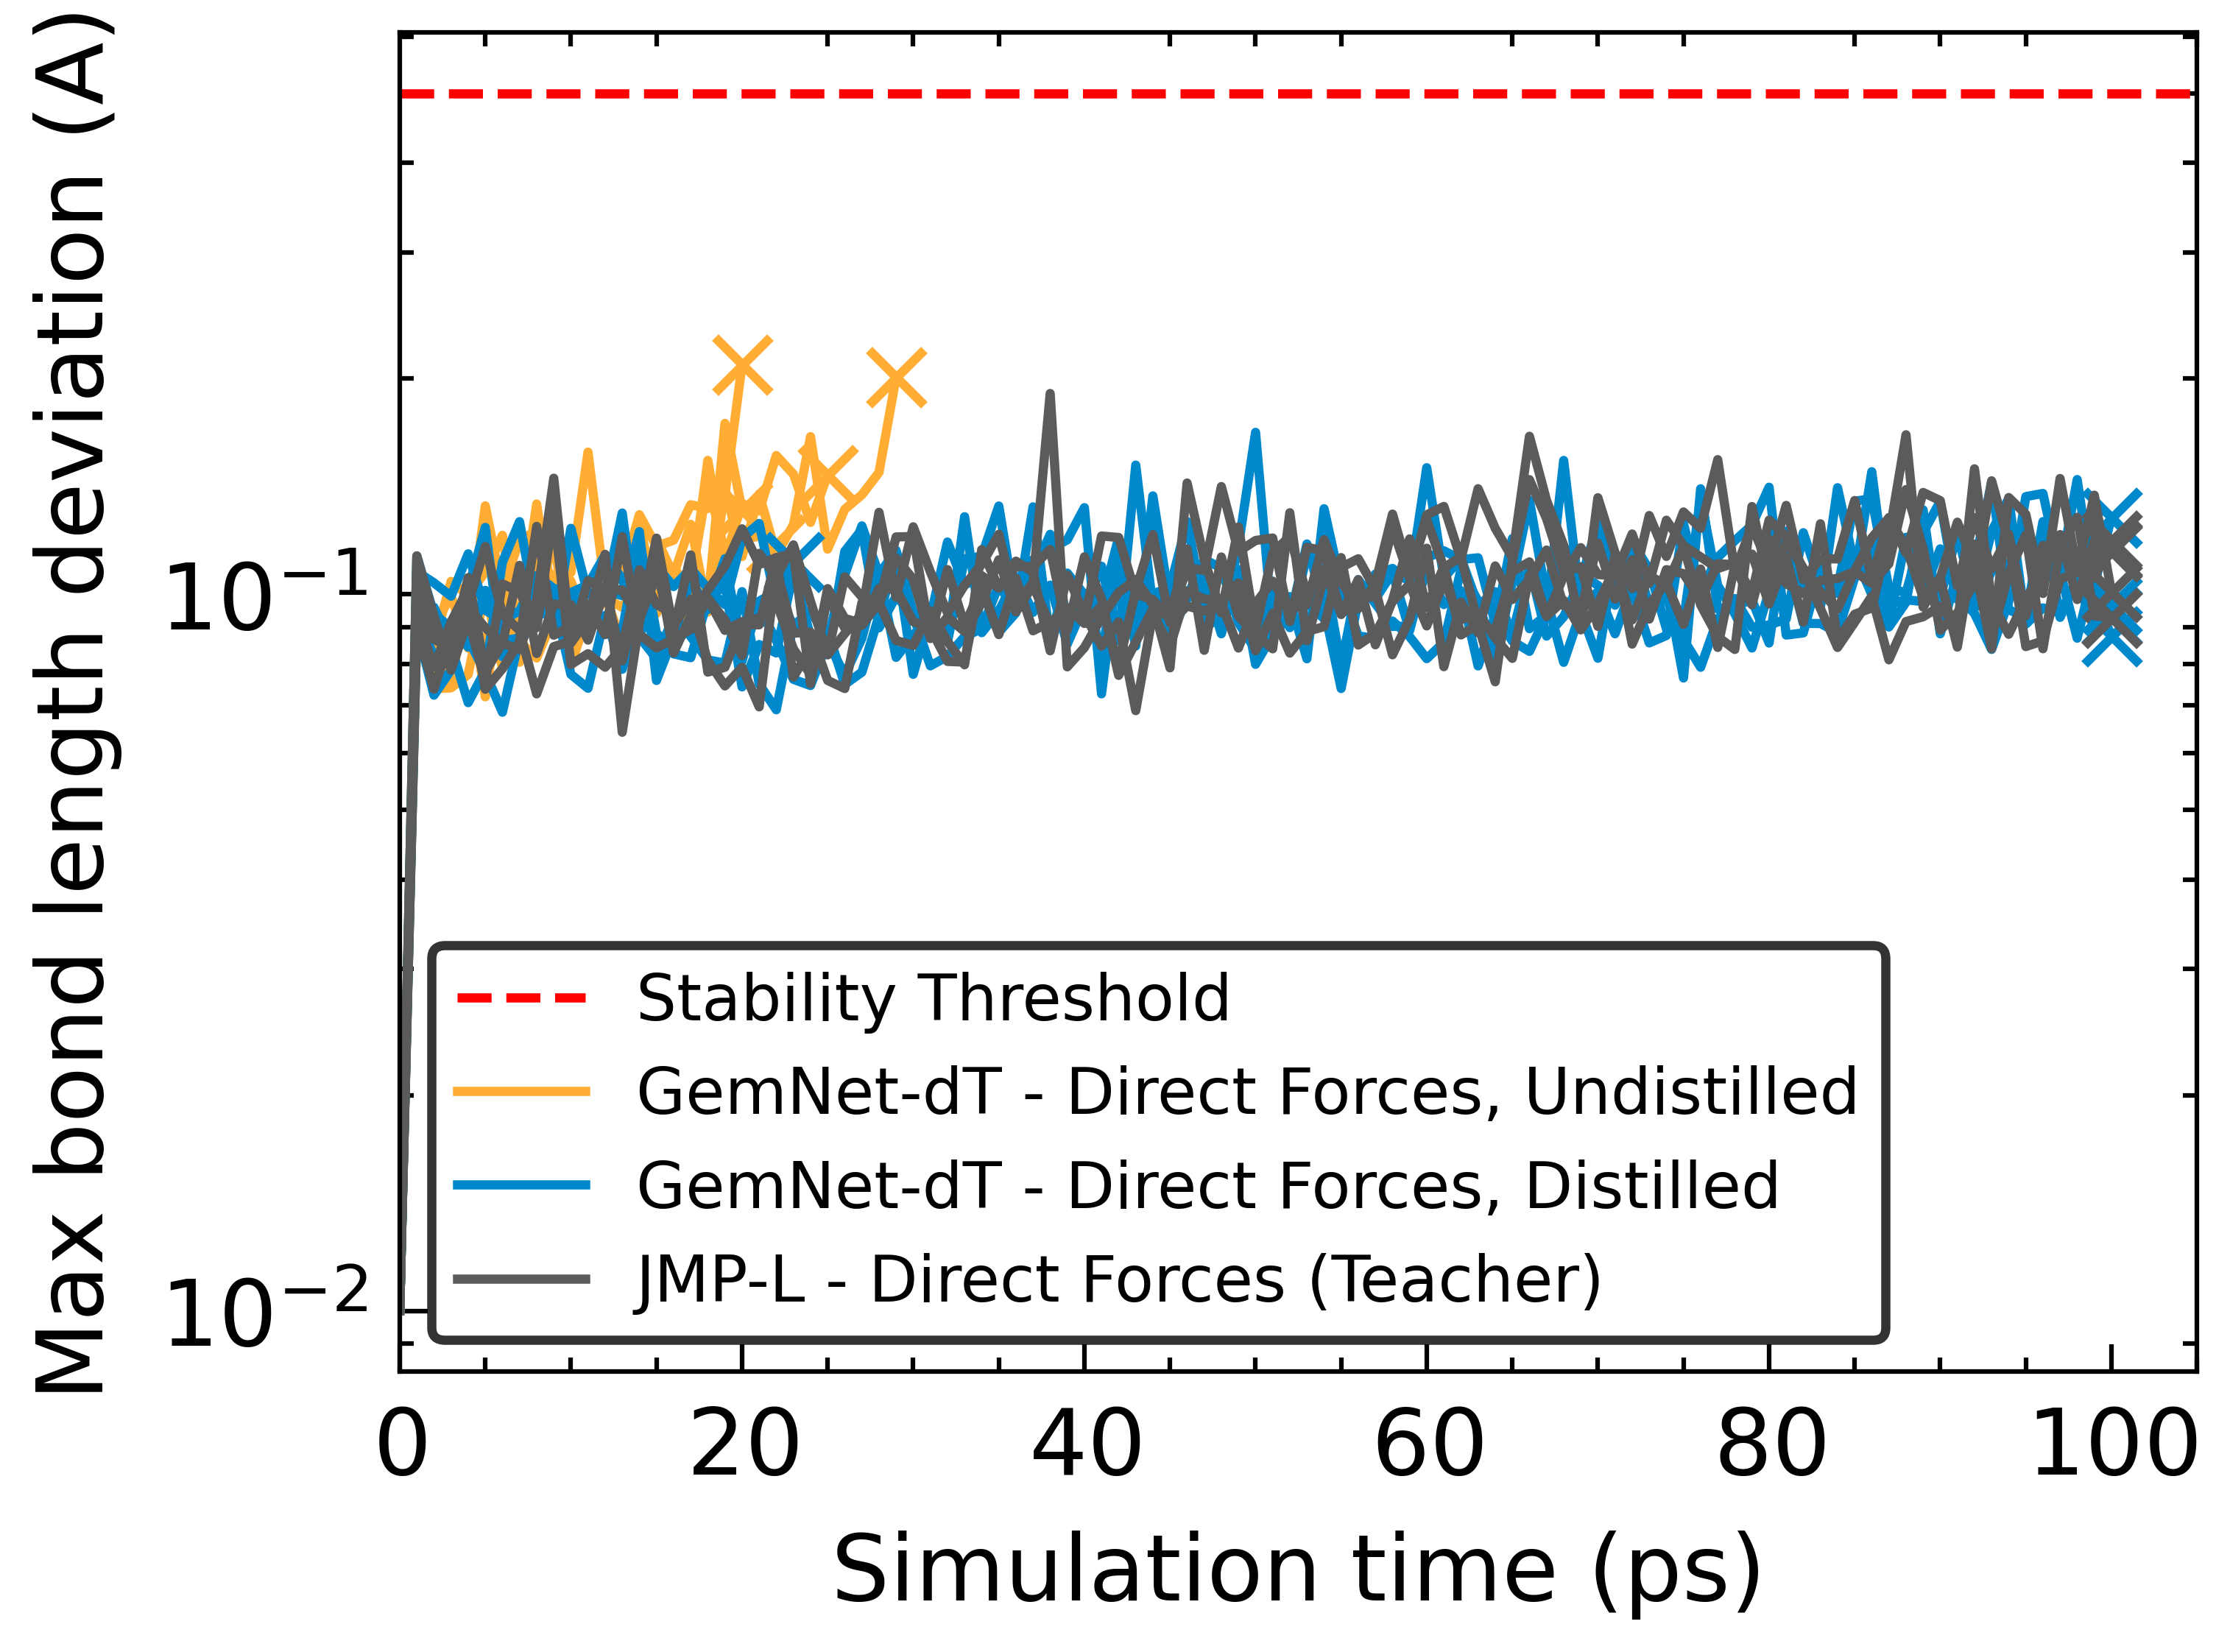

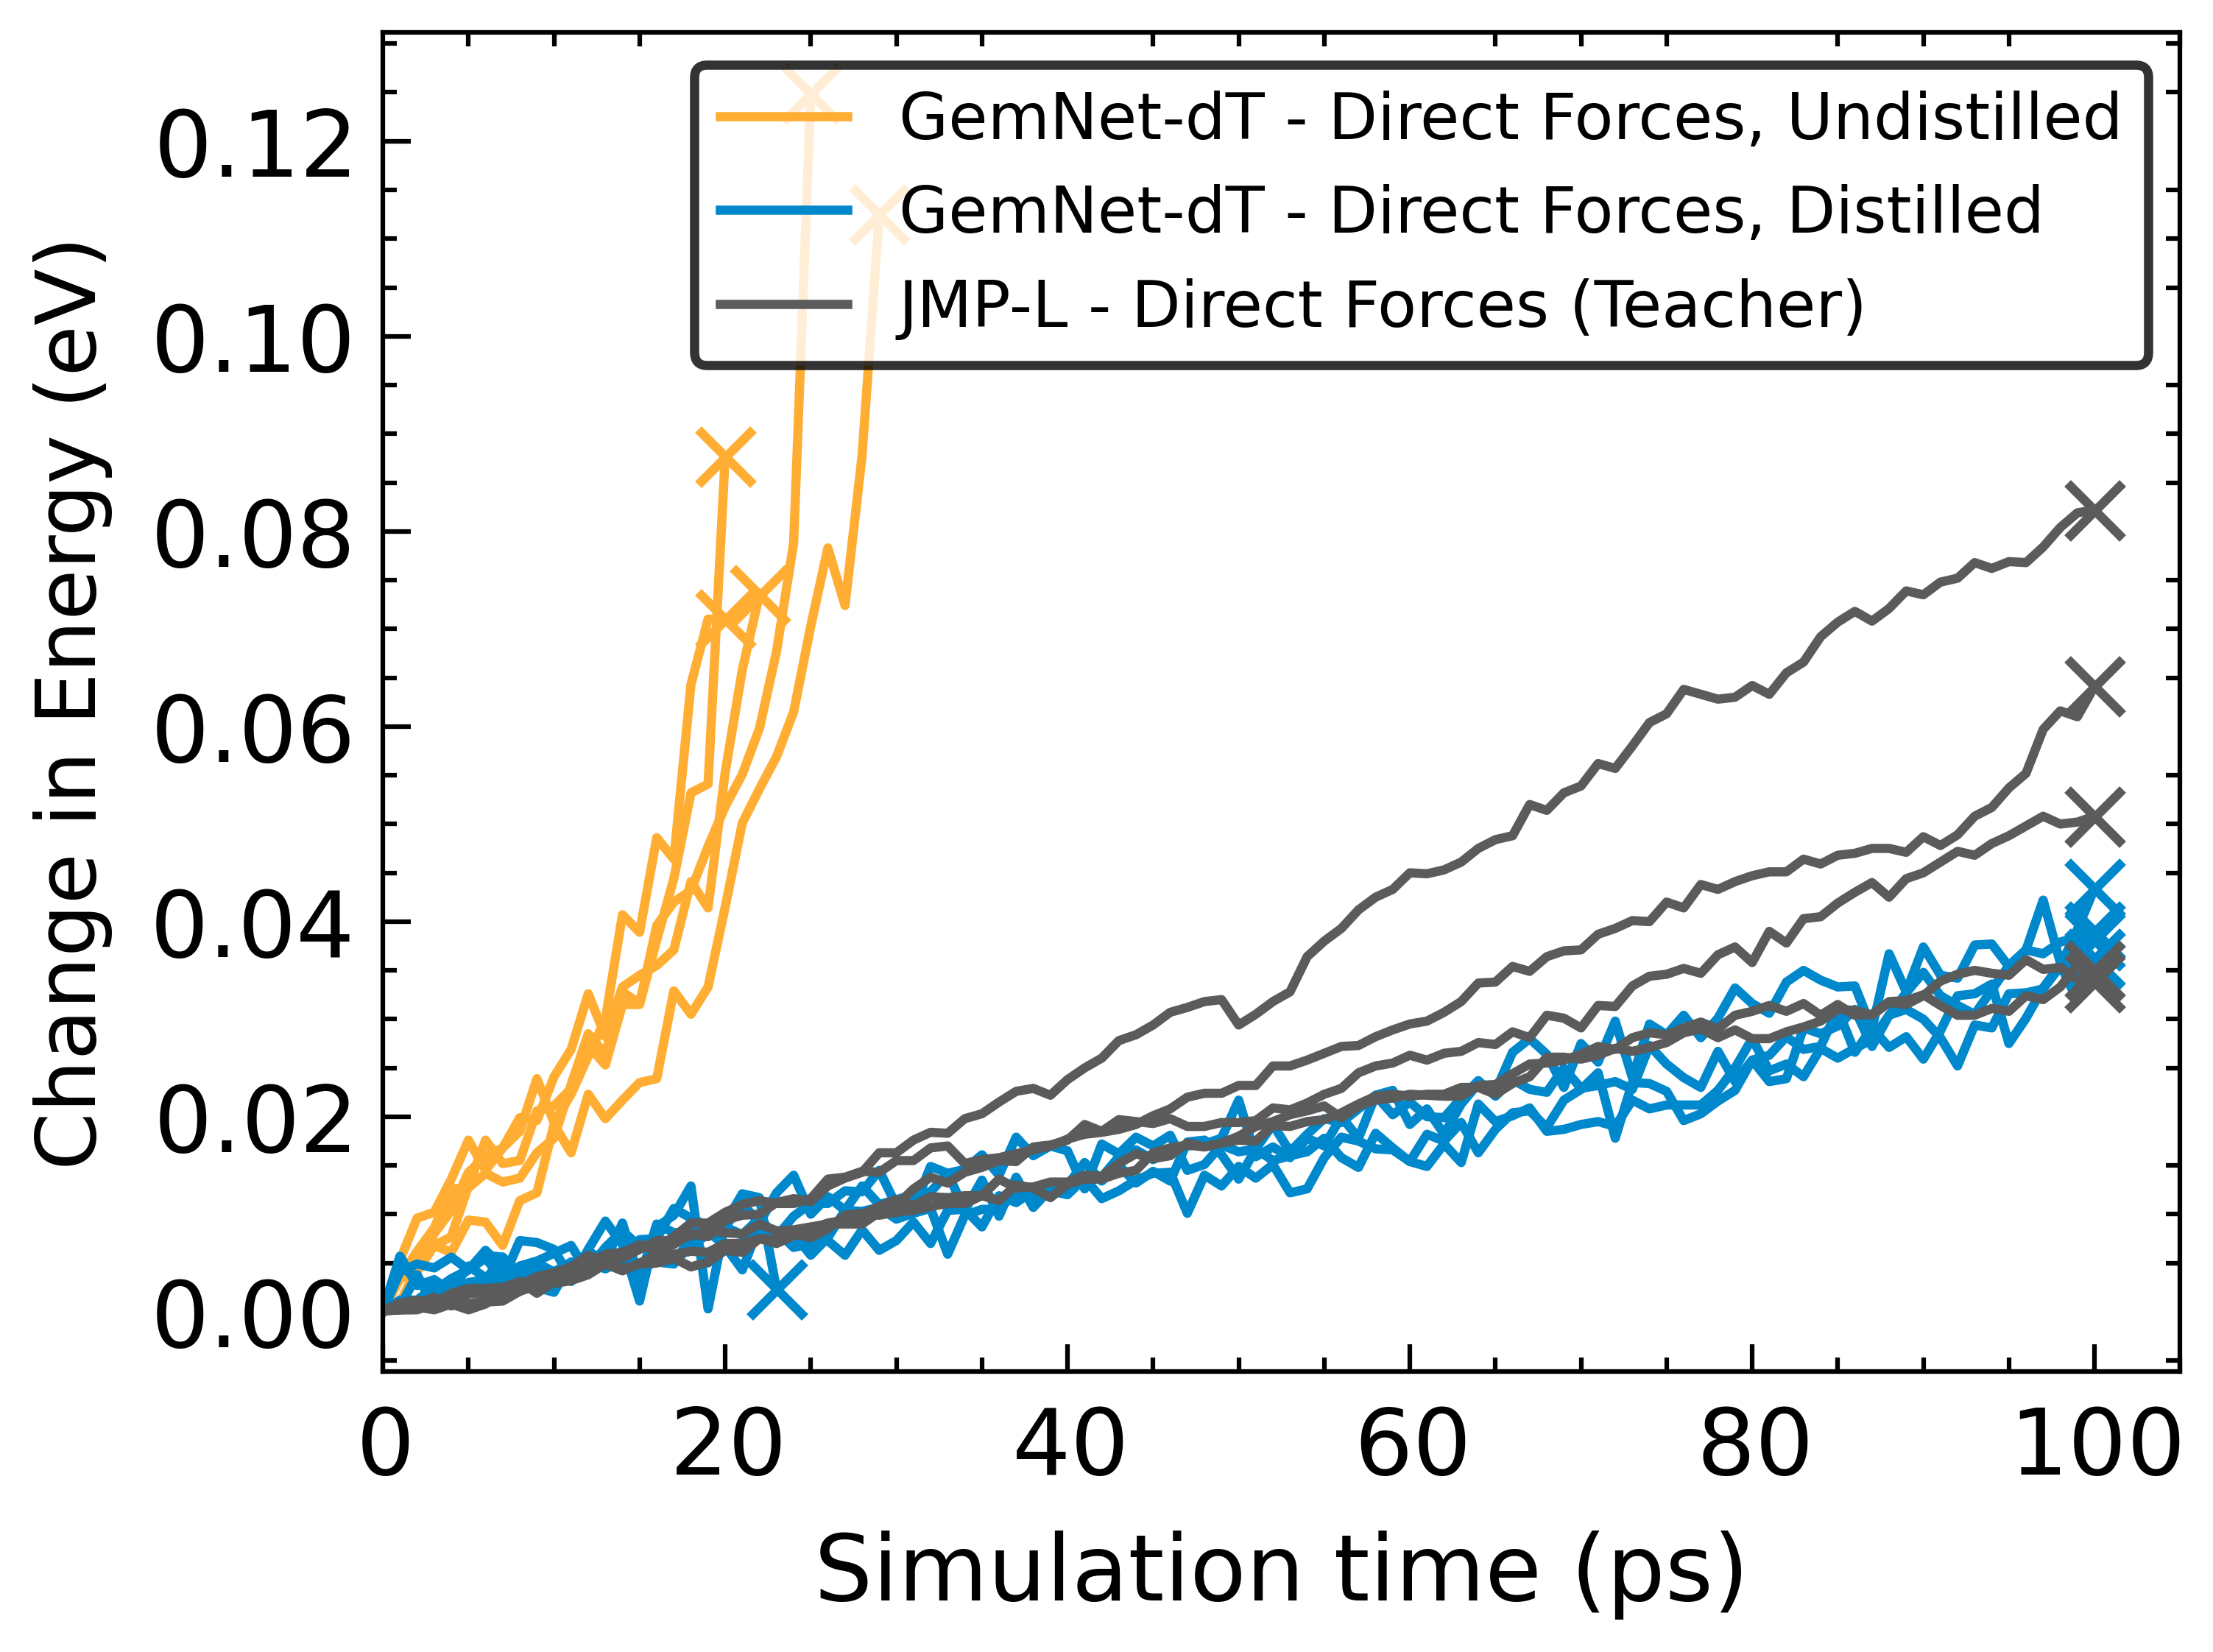

100%|██████████| 100/100 [00:00<00:00, 3229.19it/s]


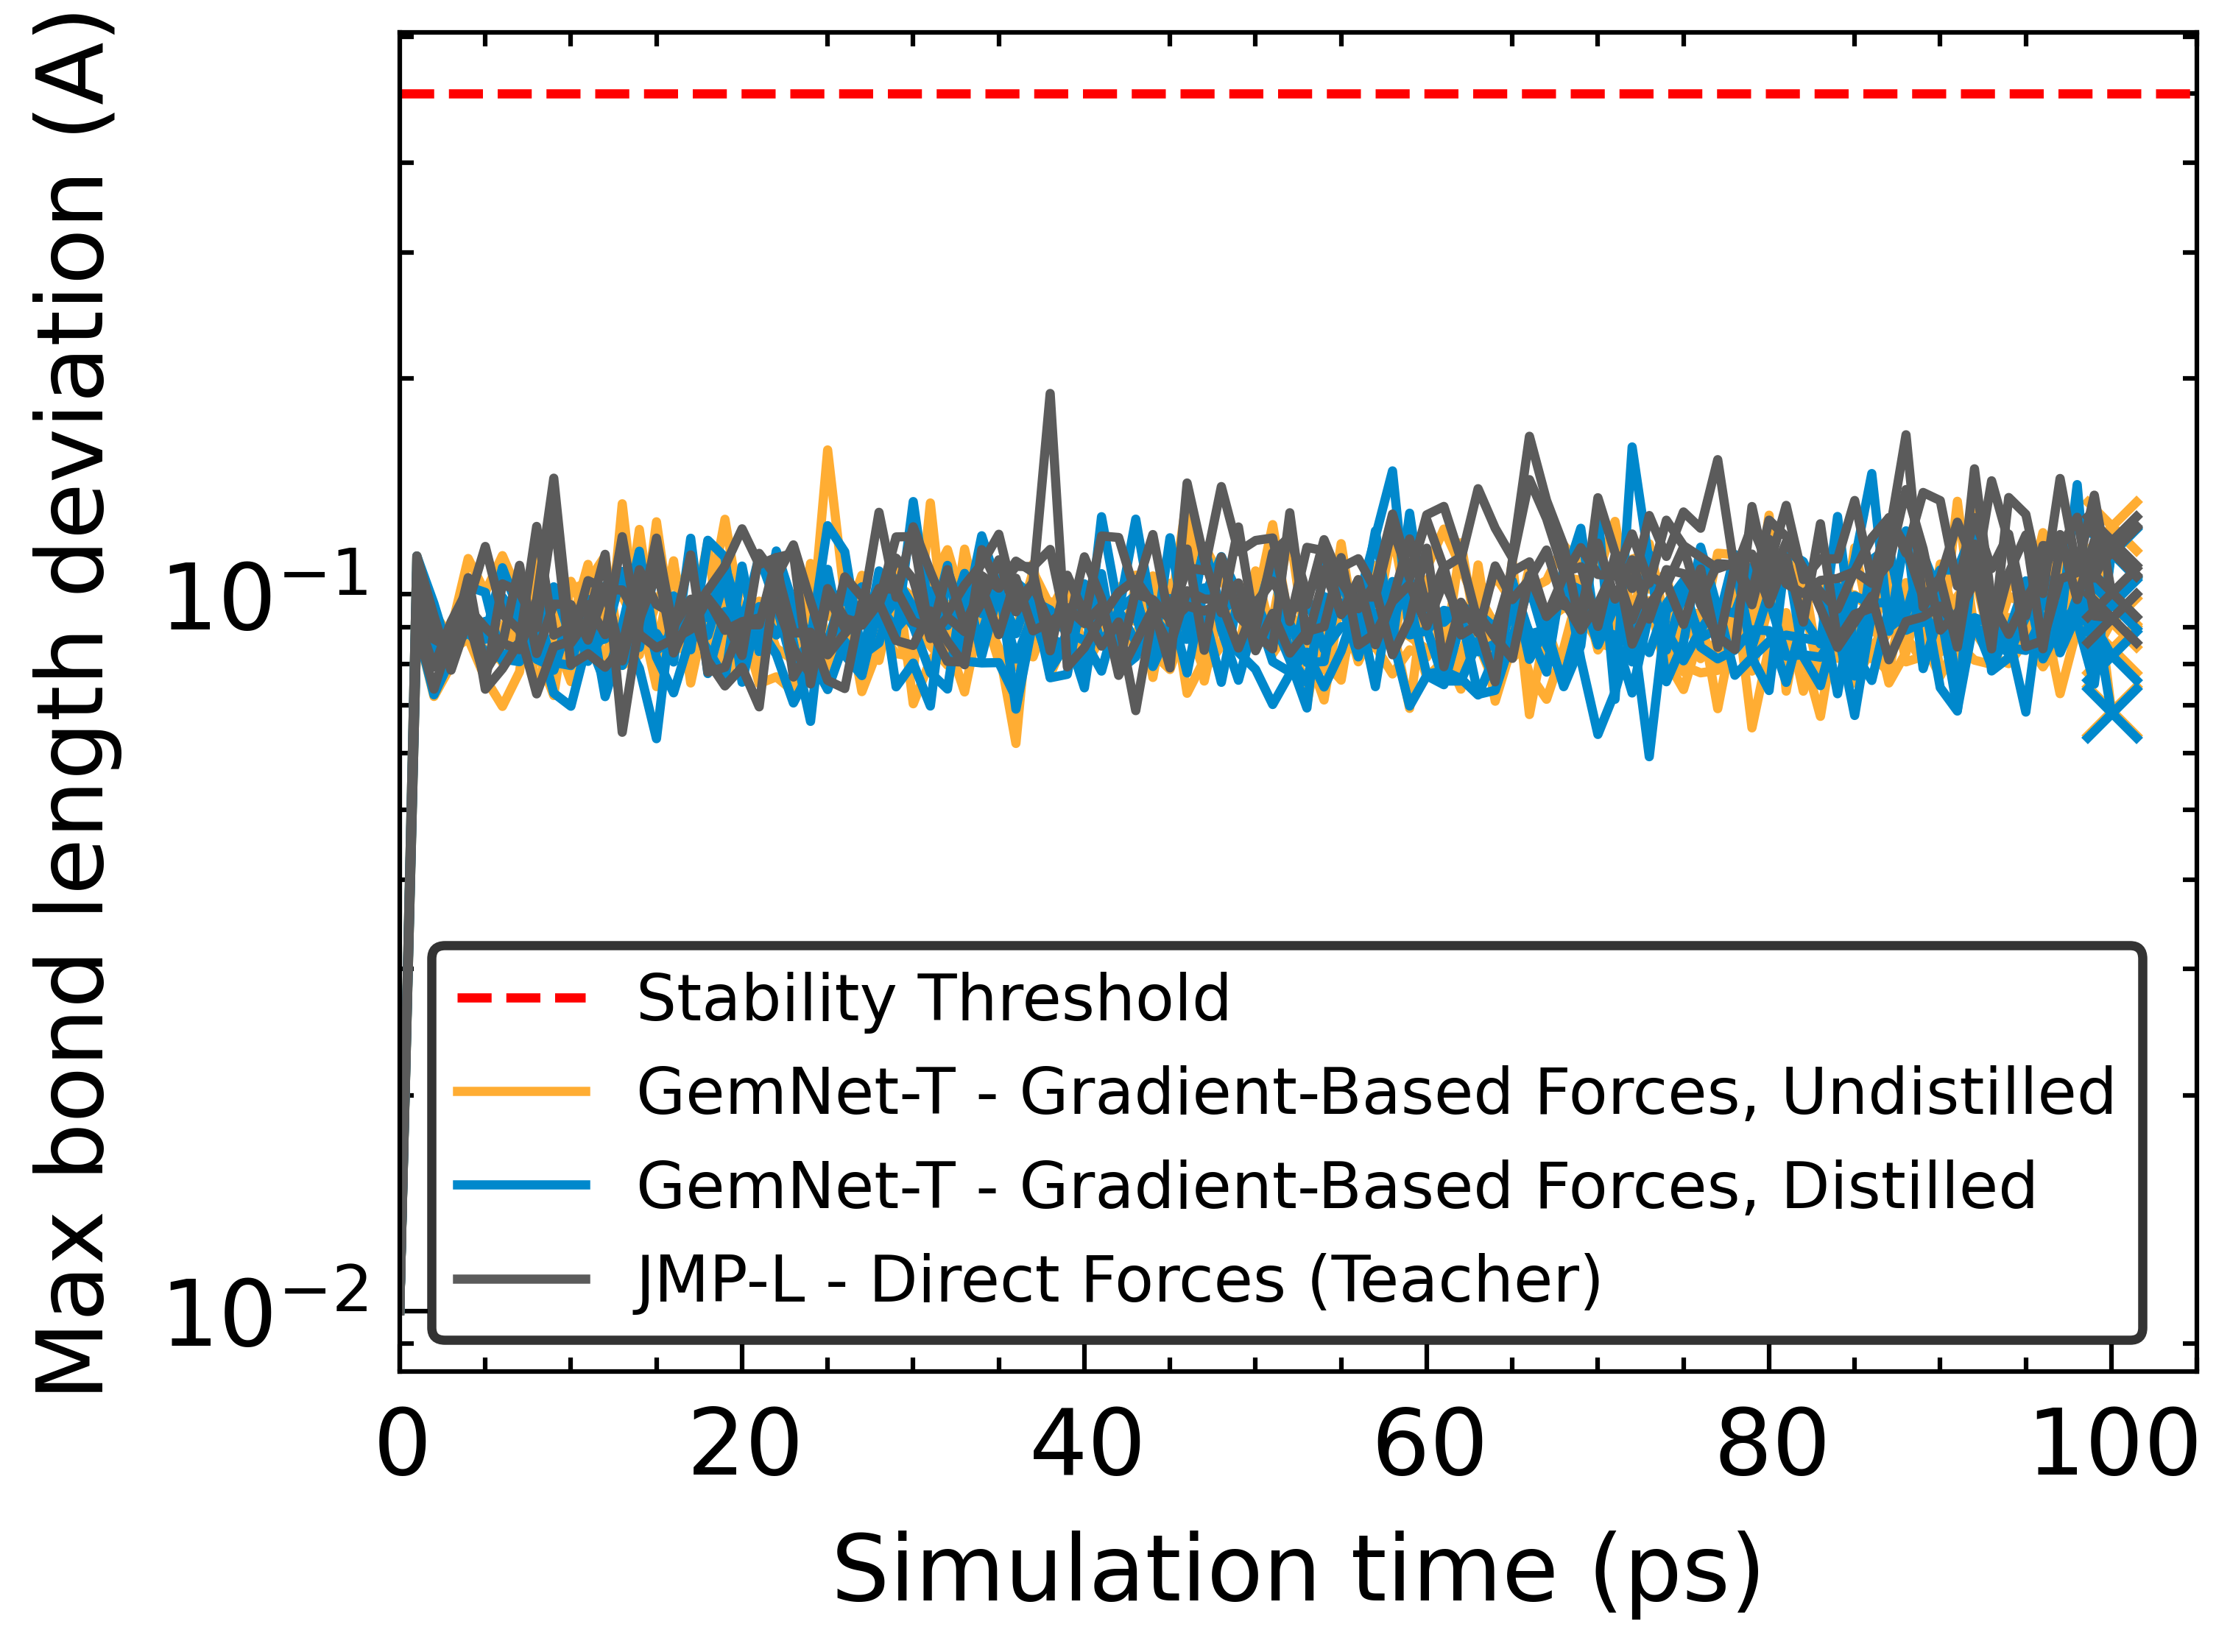

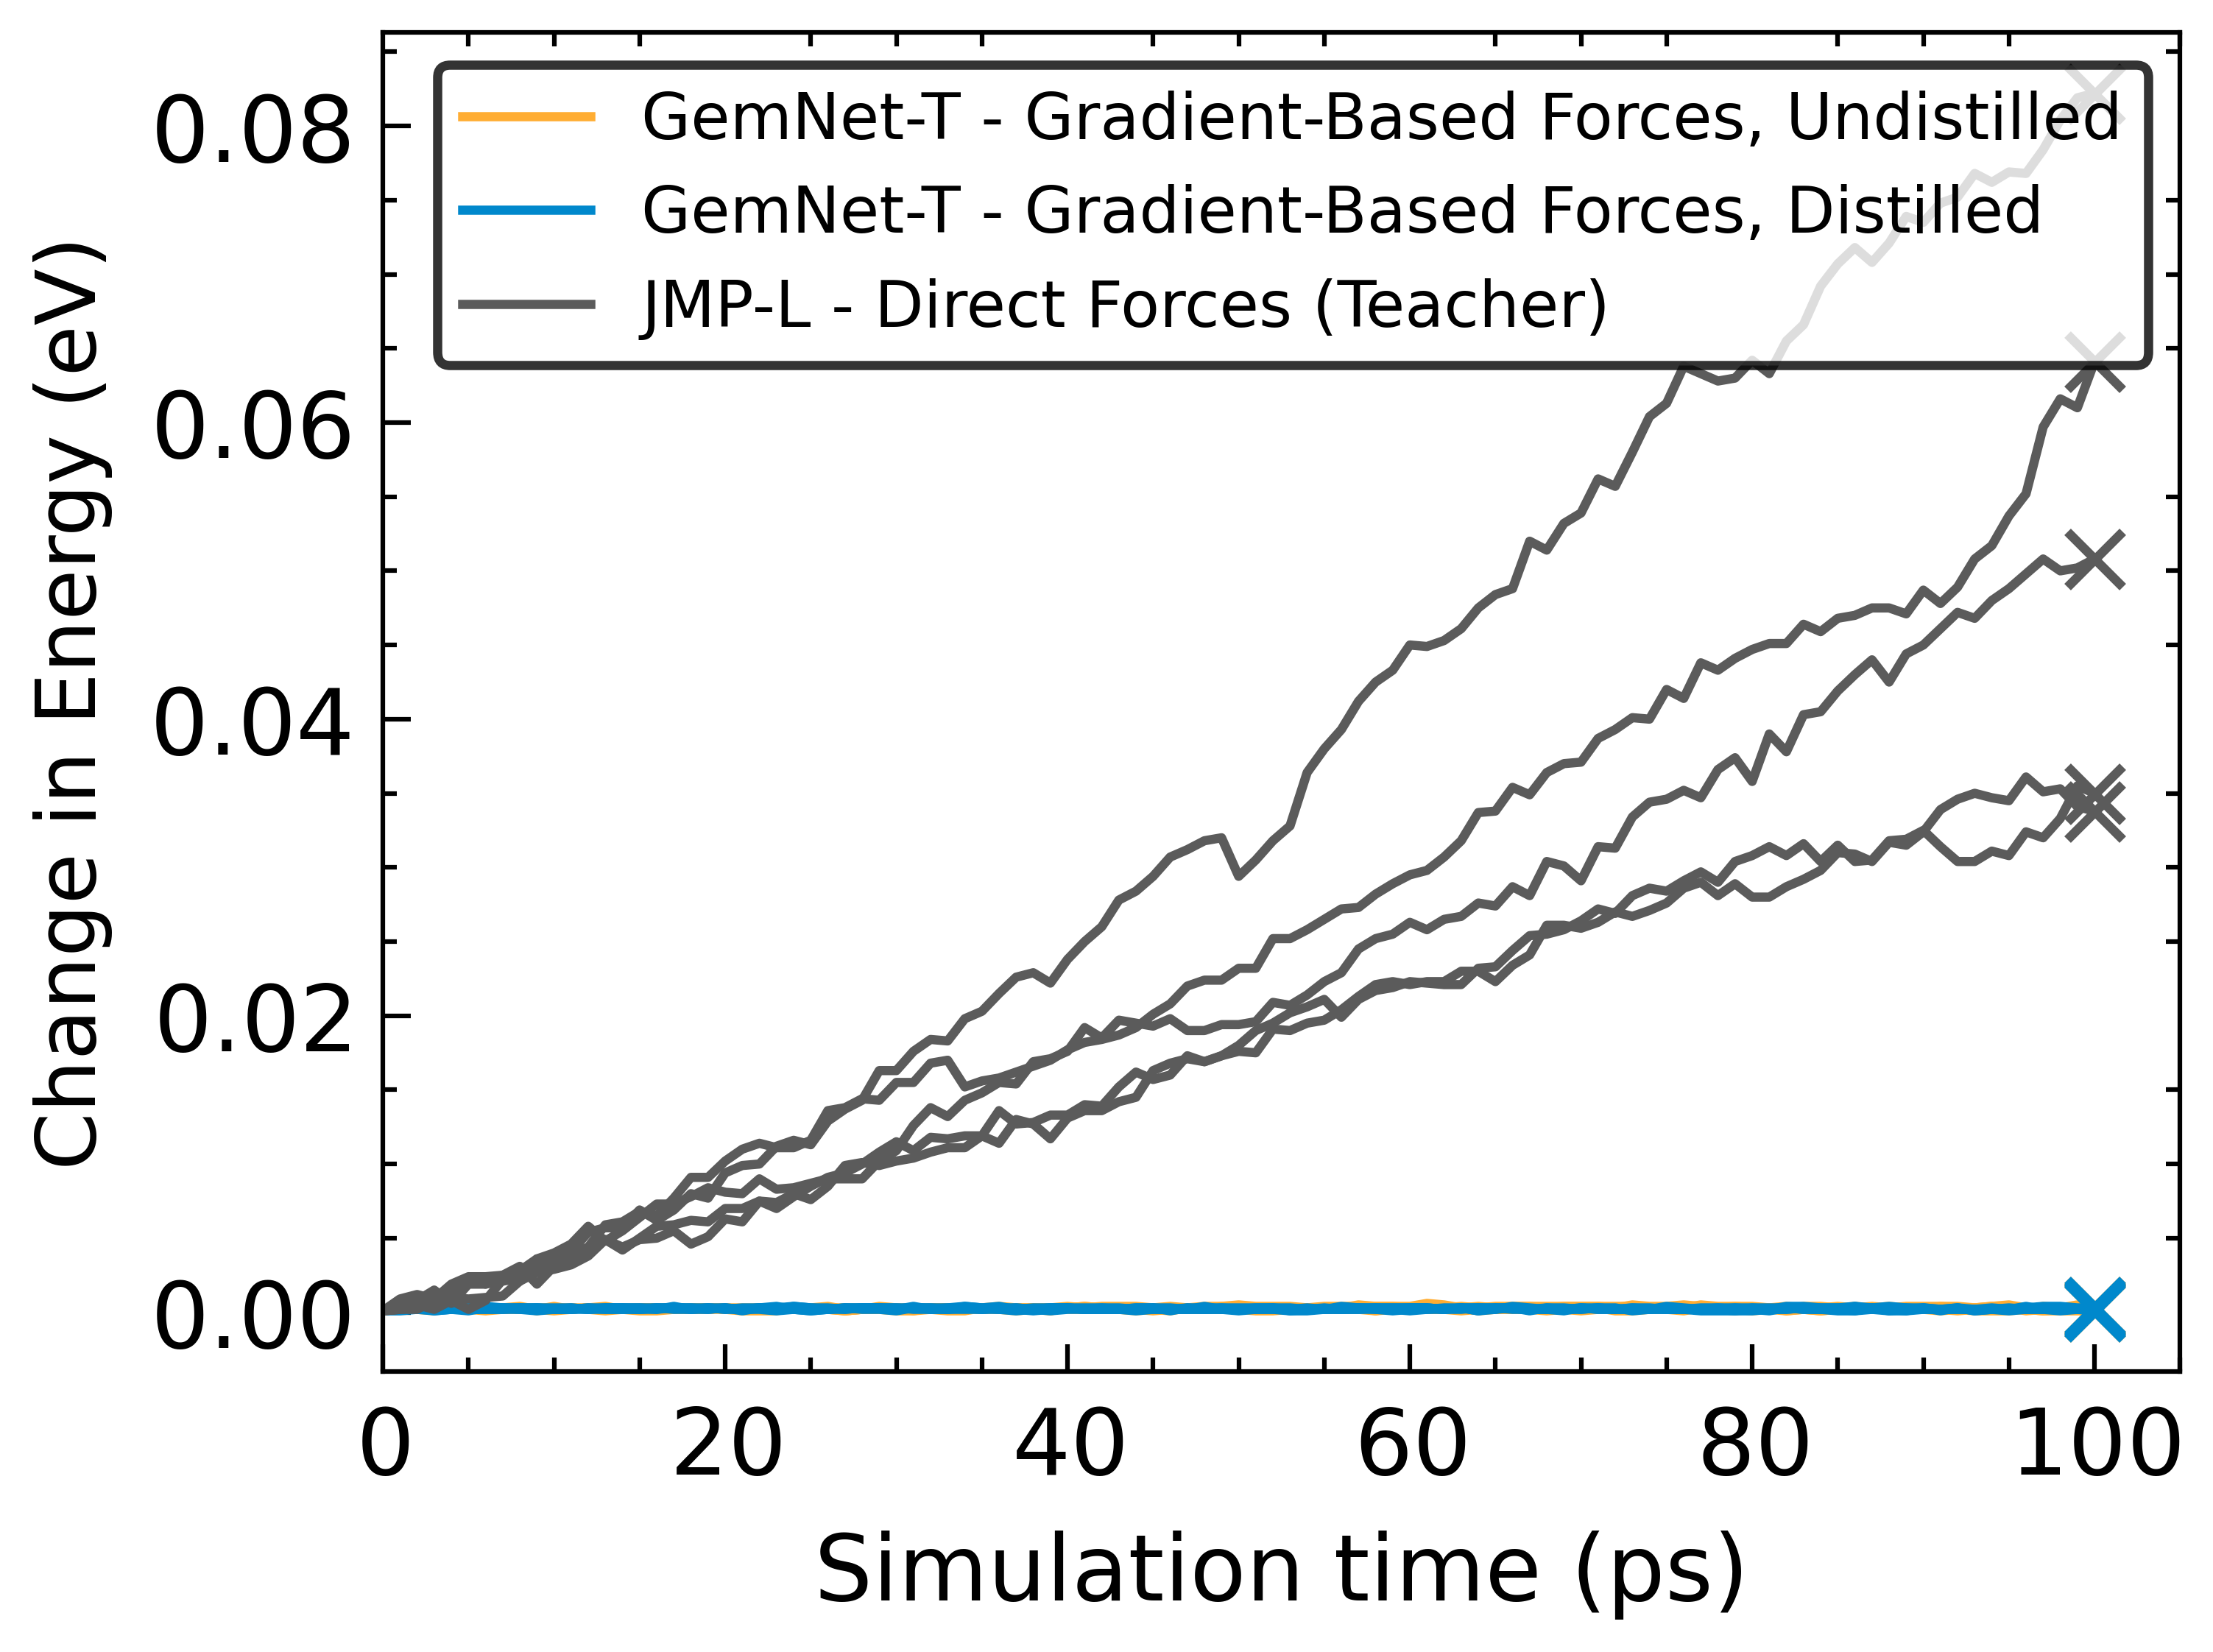

In [3]:
# Basic stability check on the trajectory (based on bond length deviations)
stability_threshold = 0.5

# Amino Acid runs
# data_split = "Solvated_Amino_Acids"

# md_dirs = ["2024-09-05-09-42-40-amino-gemSmall", "2024-09-05-13-45-52-solvated-gemSmall-DIST-4s"]
# plot_stability(data_split, md_dirs, "gem_solvated")
# md_dirs = ["2024-09-15-12-44-00-solvated_PaiNNpbc", "2024-09-15-14-45-36-solvated-Painn-DIST-pbc"]
# plot_stability(data_split, md_dirs, "painn_solvated")

# Monomer runs
# data_split = "DES370K_Monomers" 

# md_dirs = ["2024-09-05-00-08-48-monomers-gemSmall", "2024-09-05-09-04-16-monomers-gemSmall-DIST"]
# plot_stability(data_split, md_dirs, "gem_monomers")
# md_dirs = ["2024-09-08-10-33-52-monomers-PaiNN-DIST", "2024-09-08-10-25-20-monomers-PaiNN"]
# plot_stability(data_split, md_dirs, "painn_monomers")

data_split = "buckyball-catcher" 

md_dirs = ["student_checkpoints/undistilled/md22/2024-11-07-11-56-48-gemSmall-buckyball", \
            "student_checkpoints/distilled/md22/2024-11-08-12-13-52-gemSmall-buckyball-dist-jmplarge", \
            "jmp_l_sims/buckyball-catcher/energyforce"
        ]

plot_stability(data_split, checkpoint_dir, md_dirs, "gem_buckyball")

md_dirs = ["student_checkpoints/undistilled/md22/2024-11-08-17-57-20-gemTSmall-buckyball-correctenergynorm", \
            "student_checkpoints/distilled/md22/2024-11-08-17-57-20-gemTSmall-buckyball-dist-jmplarge-correctenergynorm", \
            "jmp_l_sims/buckyball-catcher/energyforce"]

plot_stability(data_split, checkpoint_dir, md_dirs, "gemT_buckyball")


/tmp/ipykernel_2195052/1647906444.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


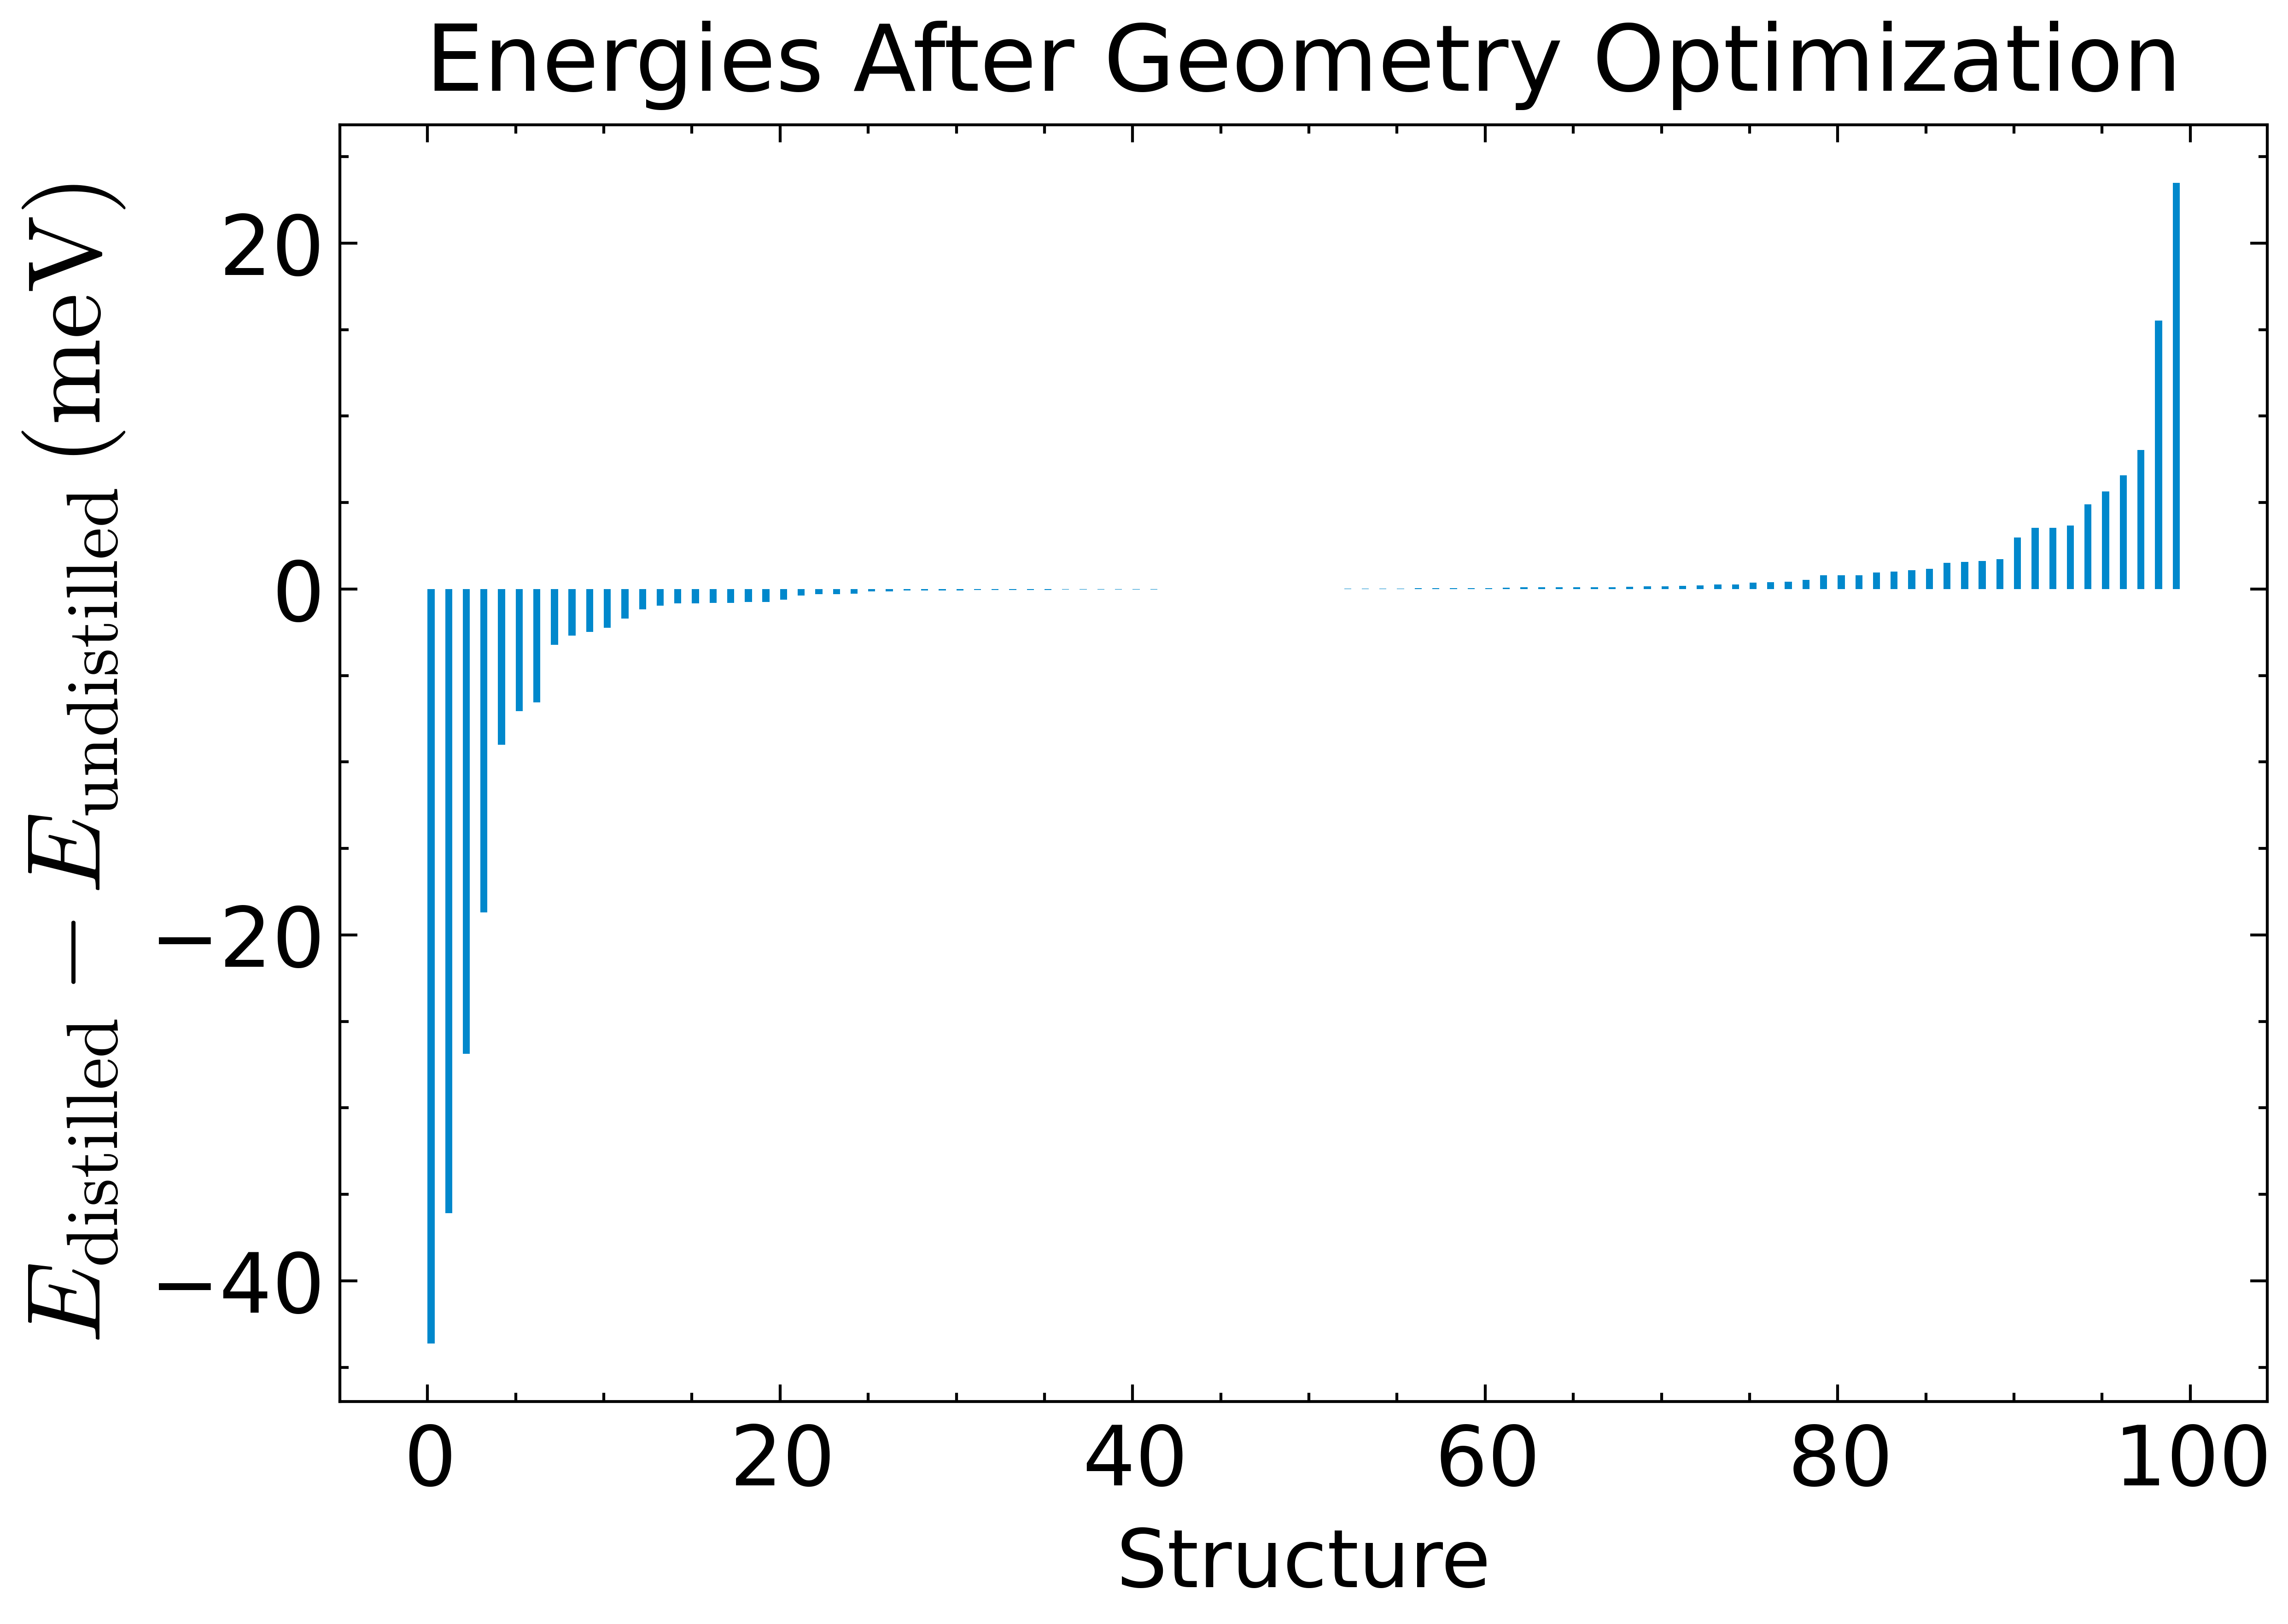

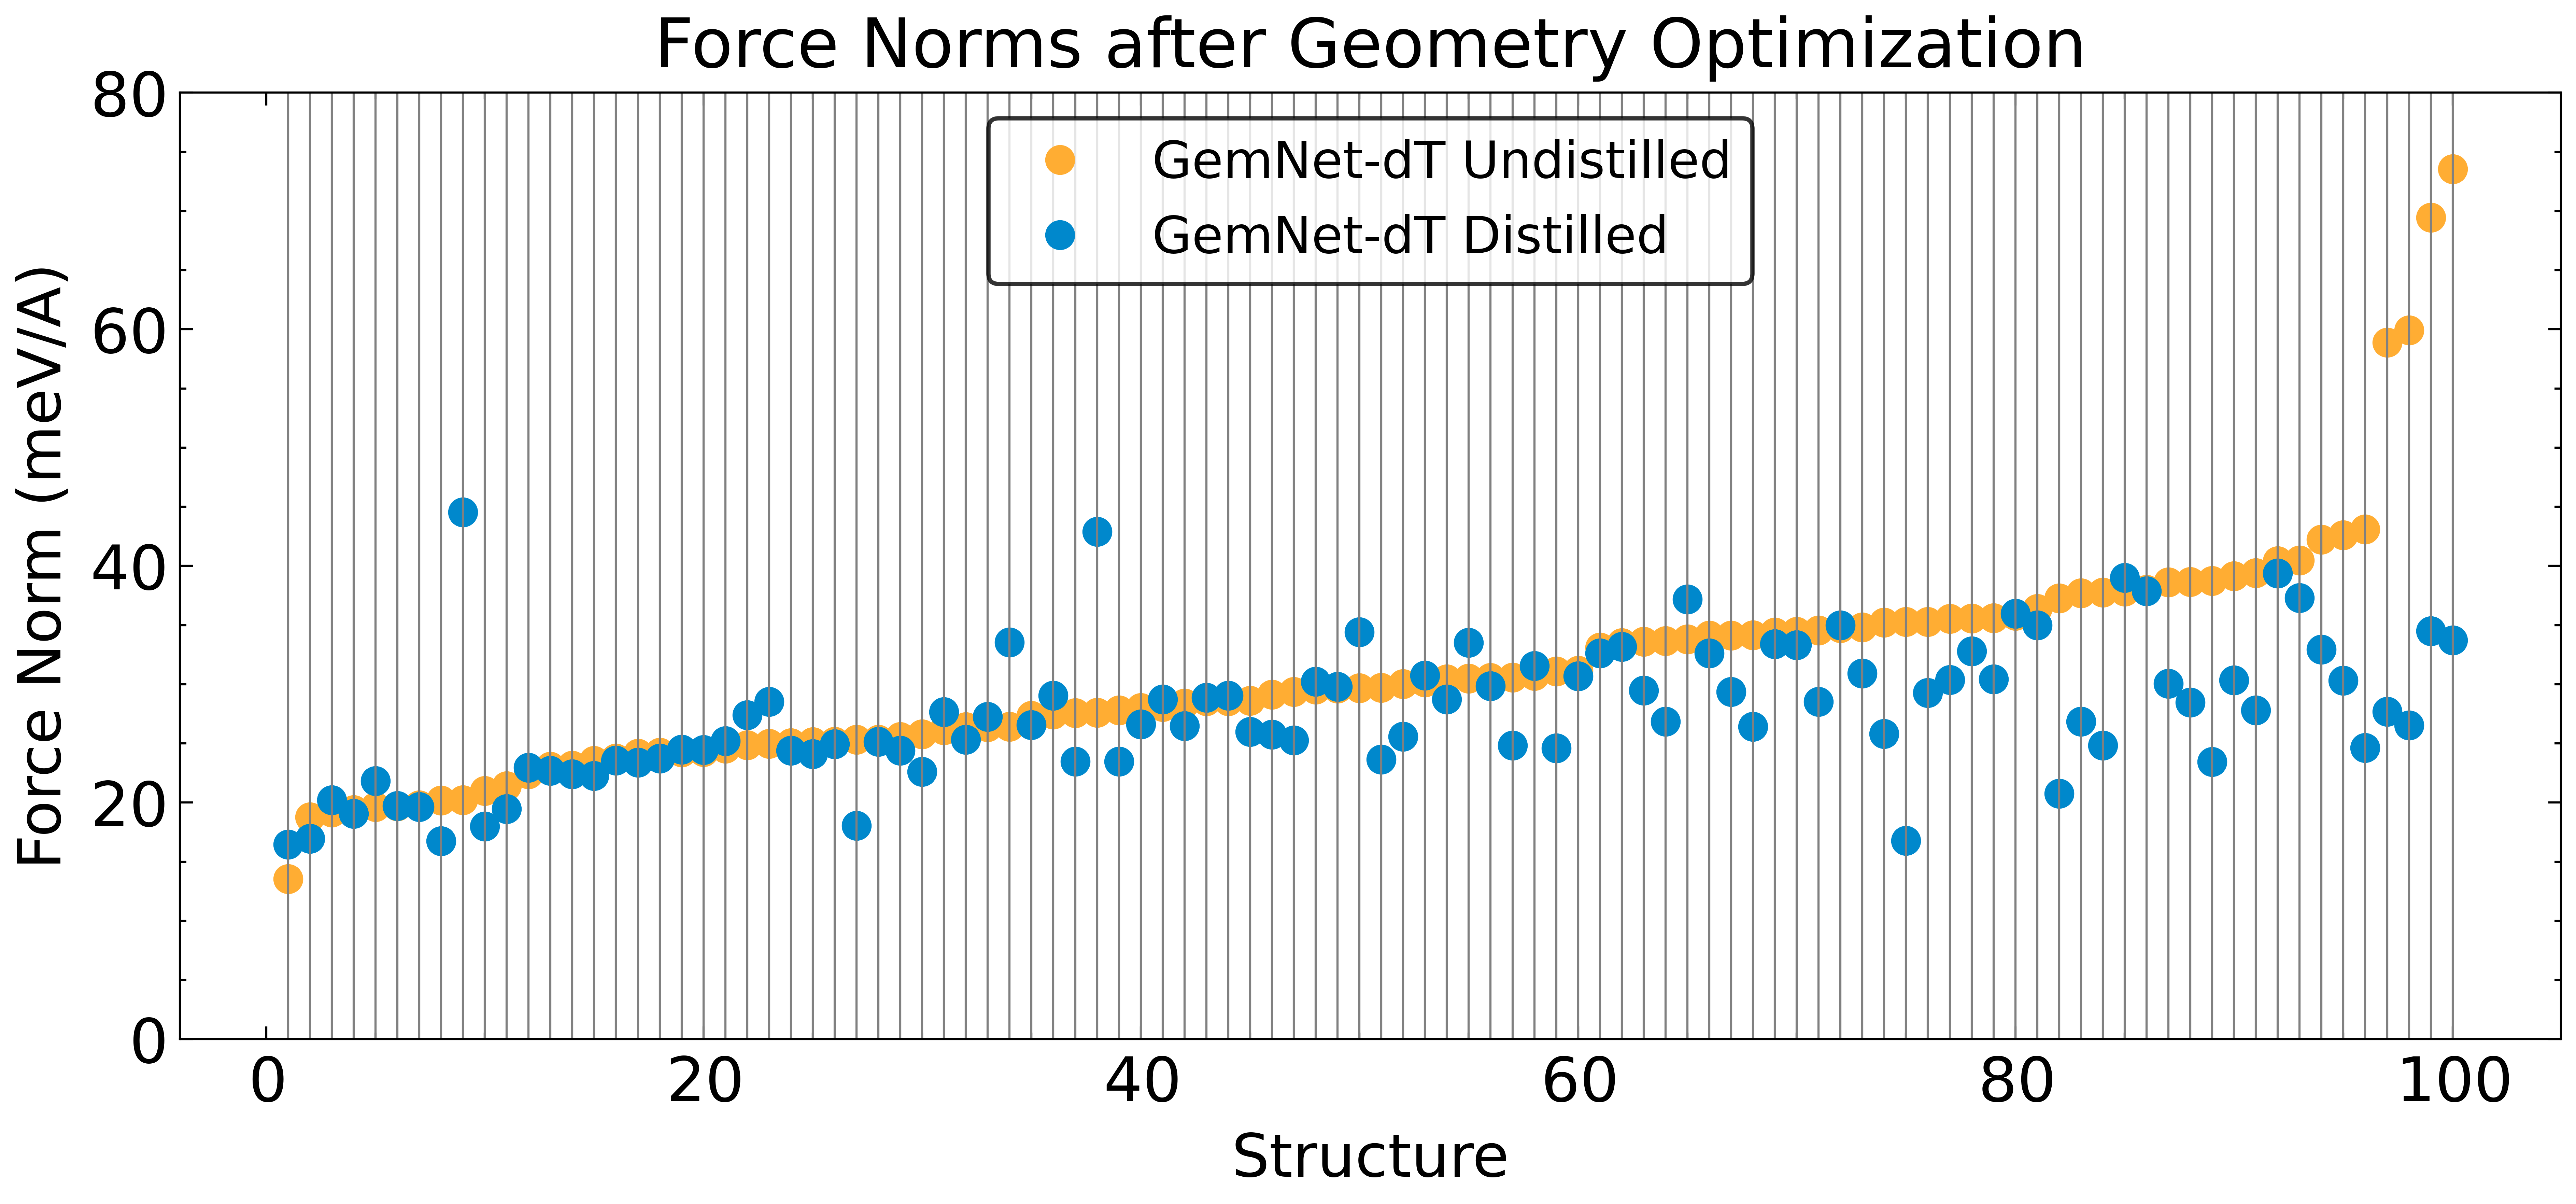

In [19]:
# Calculate energy differences and sort indices by difference
base_dir = "data/student_checkpoints/spice"
run_1 = "2024-09-05-00-08-48-monomers-gemSmall"
run_2 = "2024-09-05-09-04-16-monomers-gemSmall-DIST"


energies_1 = np.load(os.path.join(base_dir, run_1, "final_dft_energies.npy"))
energies_2 = np.load(os.path.join(base_dir, run_2, "final_dft_energies.npy"))
forces_1 = np.load(os.path.join(base_dir, run_1, "final_dft_force_norms.npy"))
forces_2 = np.load(os.path.join(base_dir, run_2, "final_dft_force_norms.npy"))


shift = np.max(energies_1)
energies_1 -= shift
energies_2 -= shift

energy_diff = 1000 * (energies_2 - energies_1)
sorted_indices_energy = np.argsort(energy_diff)

# Sorted energies
energies_1_sorted = 1000 * energies_1[sorted_indices_energy]
energies_2_sorted = 1000 * energies_2[sorted_indices_energy]


# Paired bar chart of energies
plt.figure(figsize=(6, 4))
bar_width = 0.4
x = np.arange(len(energies_1_sorted))
# plt.bar(x - bar_width/2, energies_1_sorted - , bar_width, label="Undistilled", color=ORANGE)
plt.bar(x + bar_width/2, energies_2_sorted - energies_1_sorted, bar_width, color=RBLUE)
# plt.axhline(0, color=ORANGE, linestyle='dashed', )
plt.xlabel("Structure", fontsize=14)
plt.ylabel(r"$E_{\mathrm{distilled}} - E_{\mathrm{undistilled}} \, (\mathrm{meV})$", fontsize=18)
plt.legend()
plt.title("Energies After Geometry Optimization", fontsize=16)
plt.savefig("paired_bar_energy.png")

# Calculate sorting indices based on lengths_1 and apply to both forces
sorted_indices = np.argsort(forces_1)
lengths_1_sorted = 1000 * forces_1[sorted_indices]
forces_2_sorted = 1000 * forces_2[sorted_indices]

# X-axis for data points
x = np.arange(1, len(forces_1_sorted) + 1)

plt.figure(figsize=(10, 4))

# Plot the first dataset as dots
plt.plot(x, forces_1_sorted, 'o', label="GemNet-dT Undistilled", color=ORANGE, markersize=6)

# Plot the second dataset as dots
plt.plot(x, forces_2_sorted, 'o', label="GemNet-dT Distilled", color=RBLUE, markersize=6)

# Add vertical lines to indicate pairing between datasets
# Add full vertical lines from top to bottom for each x position
for i in range(len(x)):
    plt.axvline(x[i], color='gray', linewidth=0.5)

plt.legend(loc='upper center', frameon=True, edgecolor='black', fontsize=12)
plt.xlabel("Structure", fontsize=14)
plt.ylabel("Force Norm (meV/A)", fontsize=14)
plt.ylim(0, 80)
plt.title("Force Norms after Geometry Optimization", fontsize=16)
plt.savefig("paired_bar_force.png")

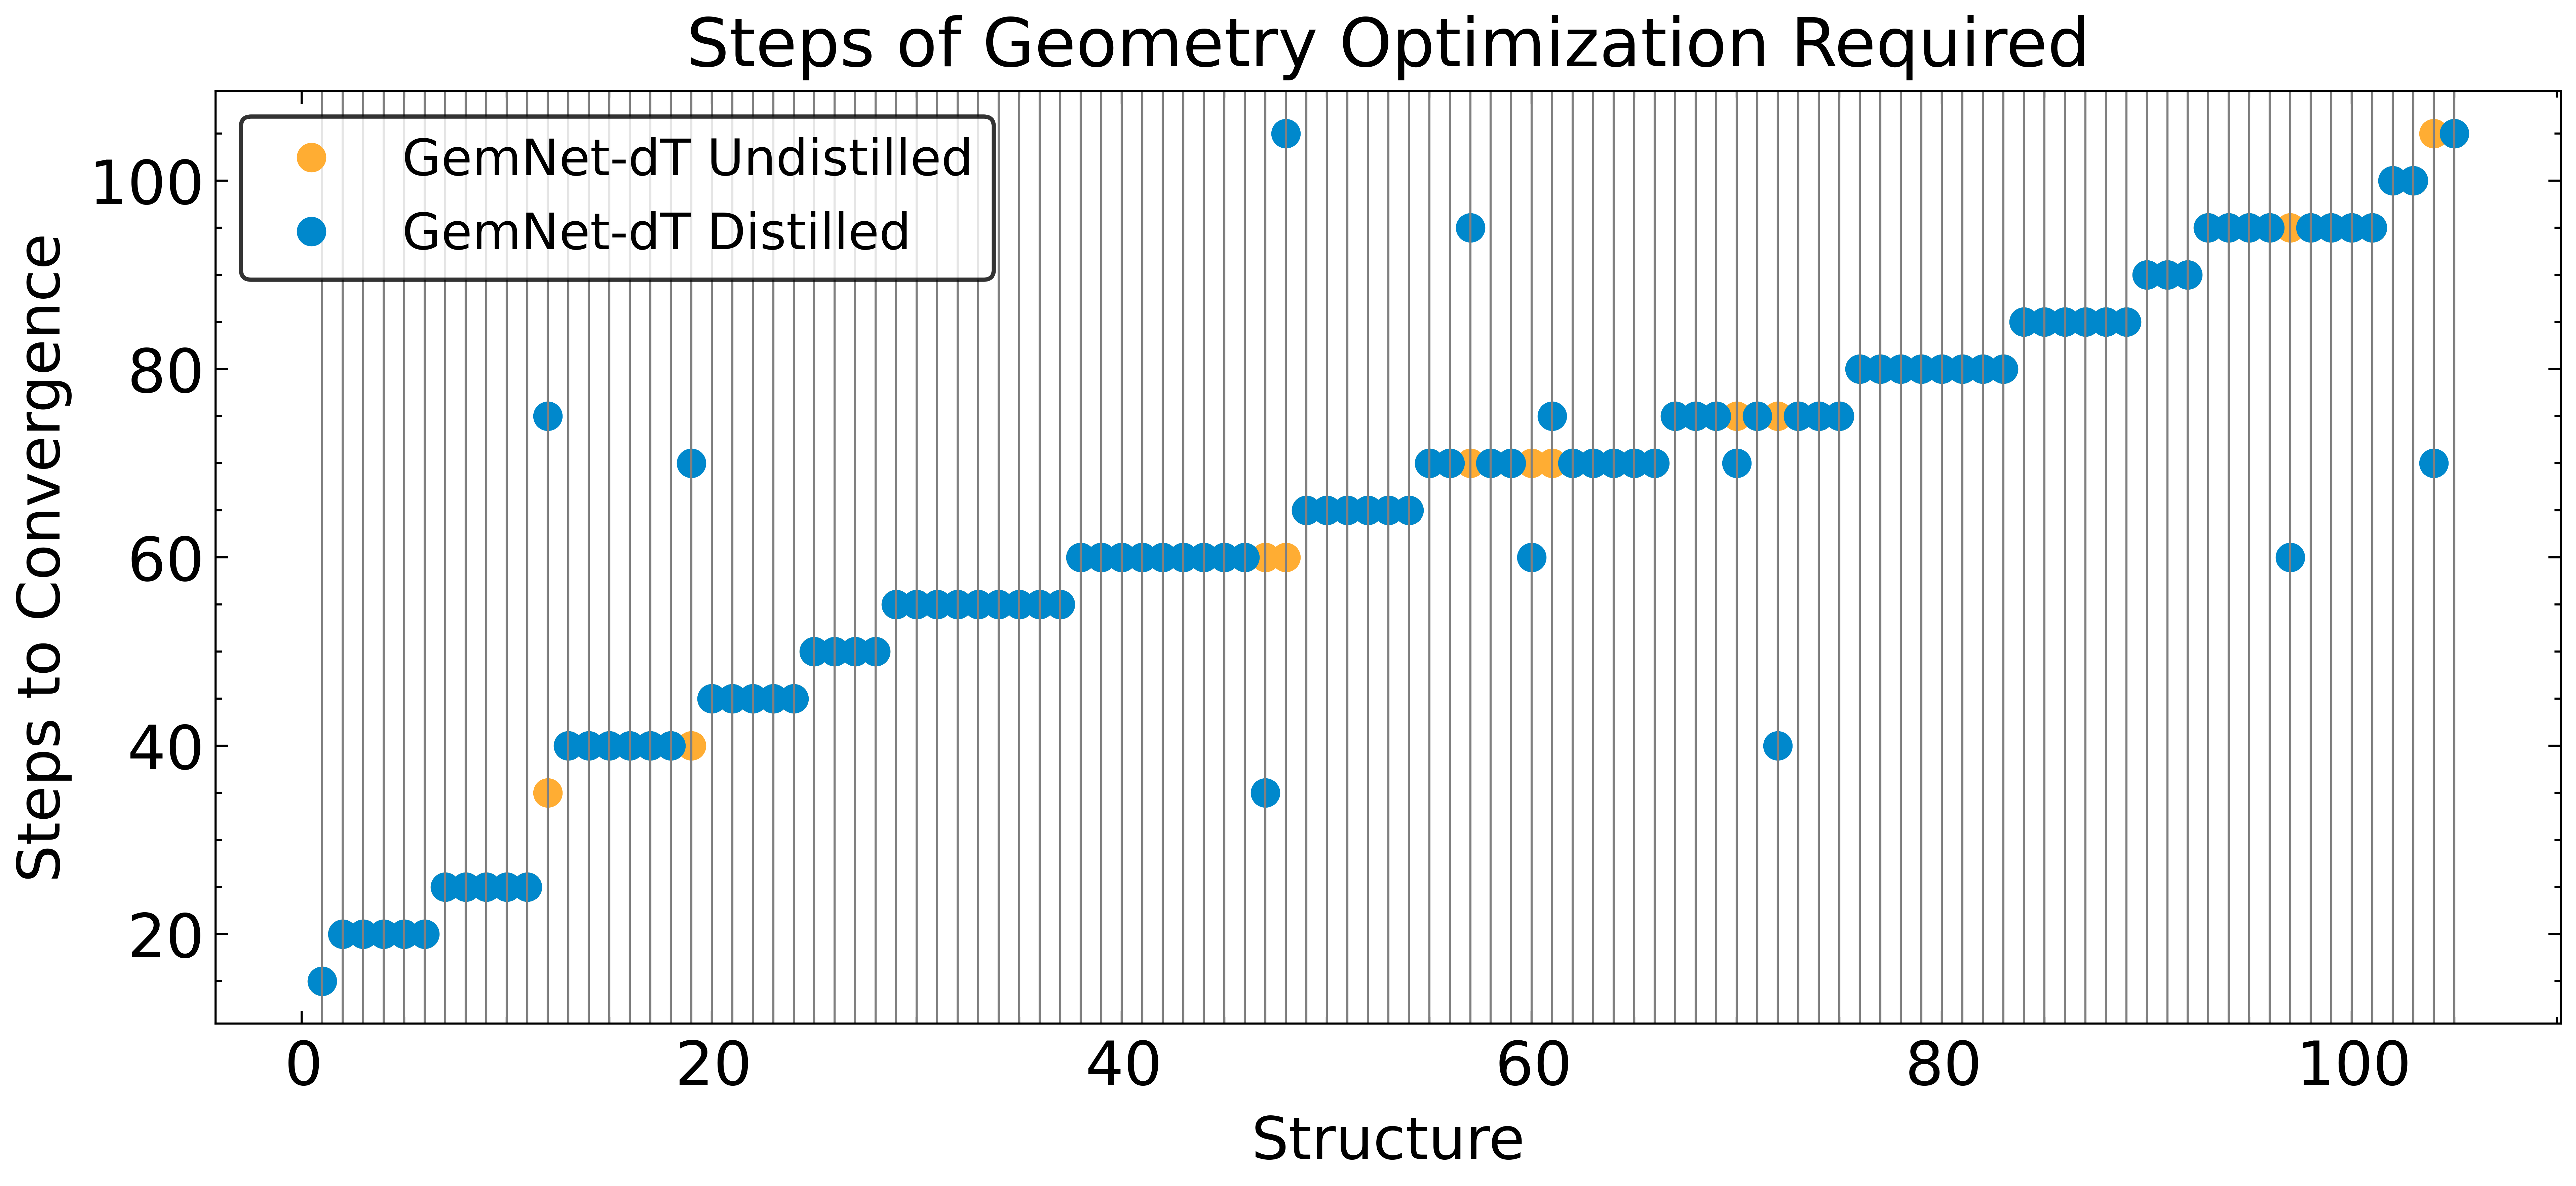

In [23]:
# Trajectory length analysis
import glob
traj_files_1 = glob.glob(os.path.join(base_dir, run_1, "*.traj"))
traj_files_2 = glob.glob(os.path.join(base_dir, run_2, "*.traj"))
# find lengths of trajectories
traj_lengths_1 = 5*np.array([len(ase.io.read(f)) for f in traj_files_1])
traj_lengths_2 = 5*np.array([len(ase.io.read(f)) for f in traj_files_2])

# Calculate sorting indices based on lengths_1 and apply to both forces
sorted_indices = np.argsort(traj_lengths_1)
lengths_1_sorted = traj_lengths_1[sorted_indices]
lengths_2_sorted = traj_lengths_2[sorted_indices]

# X-axis for data points
x = np.arange(1, len(lengths_1_sorted) + 1)

plt.figure(figsize=(10, 4))

# Plot the first dataset as dots
plt.plot(x, lengths_1_sorted, 'o', label="GemNet-dT Undistilled", color=ORANGE, markersize=6)

# Plot the second dataset as dots
plt.plot(x, lengths_2_sorted, 'o', label="GemNet-dT Distilled", color=RBLUE, markersize=6)

# Add vertical lines to indicate pairing between datasets
# Add full vertical lines from top to bottom for each x position
for i in range(len(x)):
    plt.axvline(x[i], color='gray', linewidth=0.5)

plt.legend(loc='upper left', frameon=True, edgecolor='black', fontsize=12)
plt.xlabel("Structure", fontsize=14)
plt.ylabel("Steps to Convergence", fontsize=14)
plt.title("Steps of Geometry Optimization Required", fontsize=16)
plt.savefig("paired_bar_steps.png")


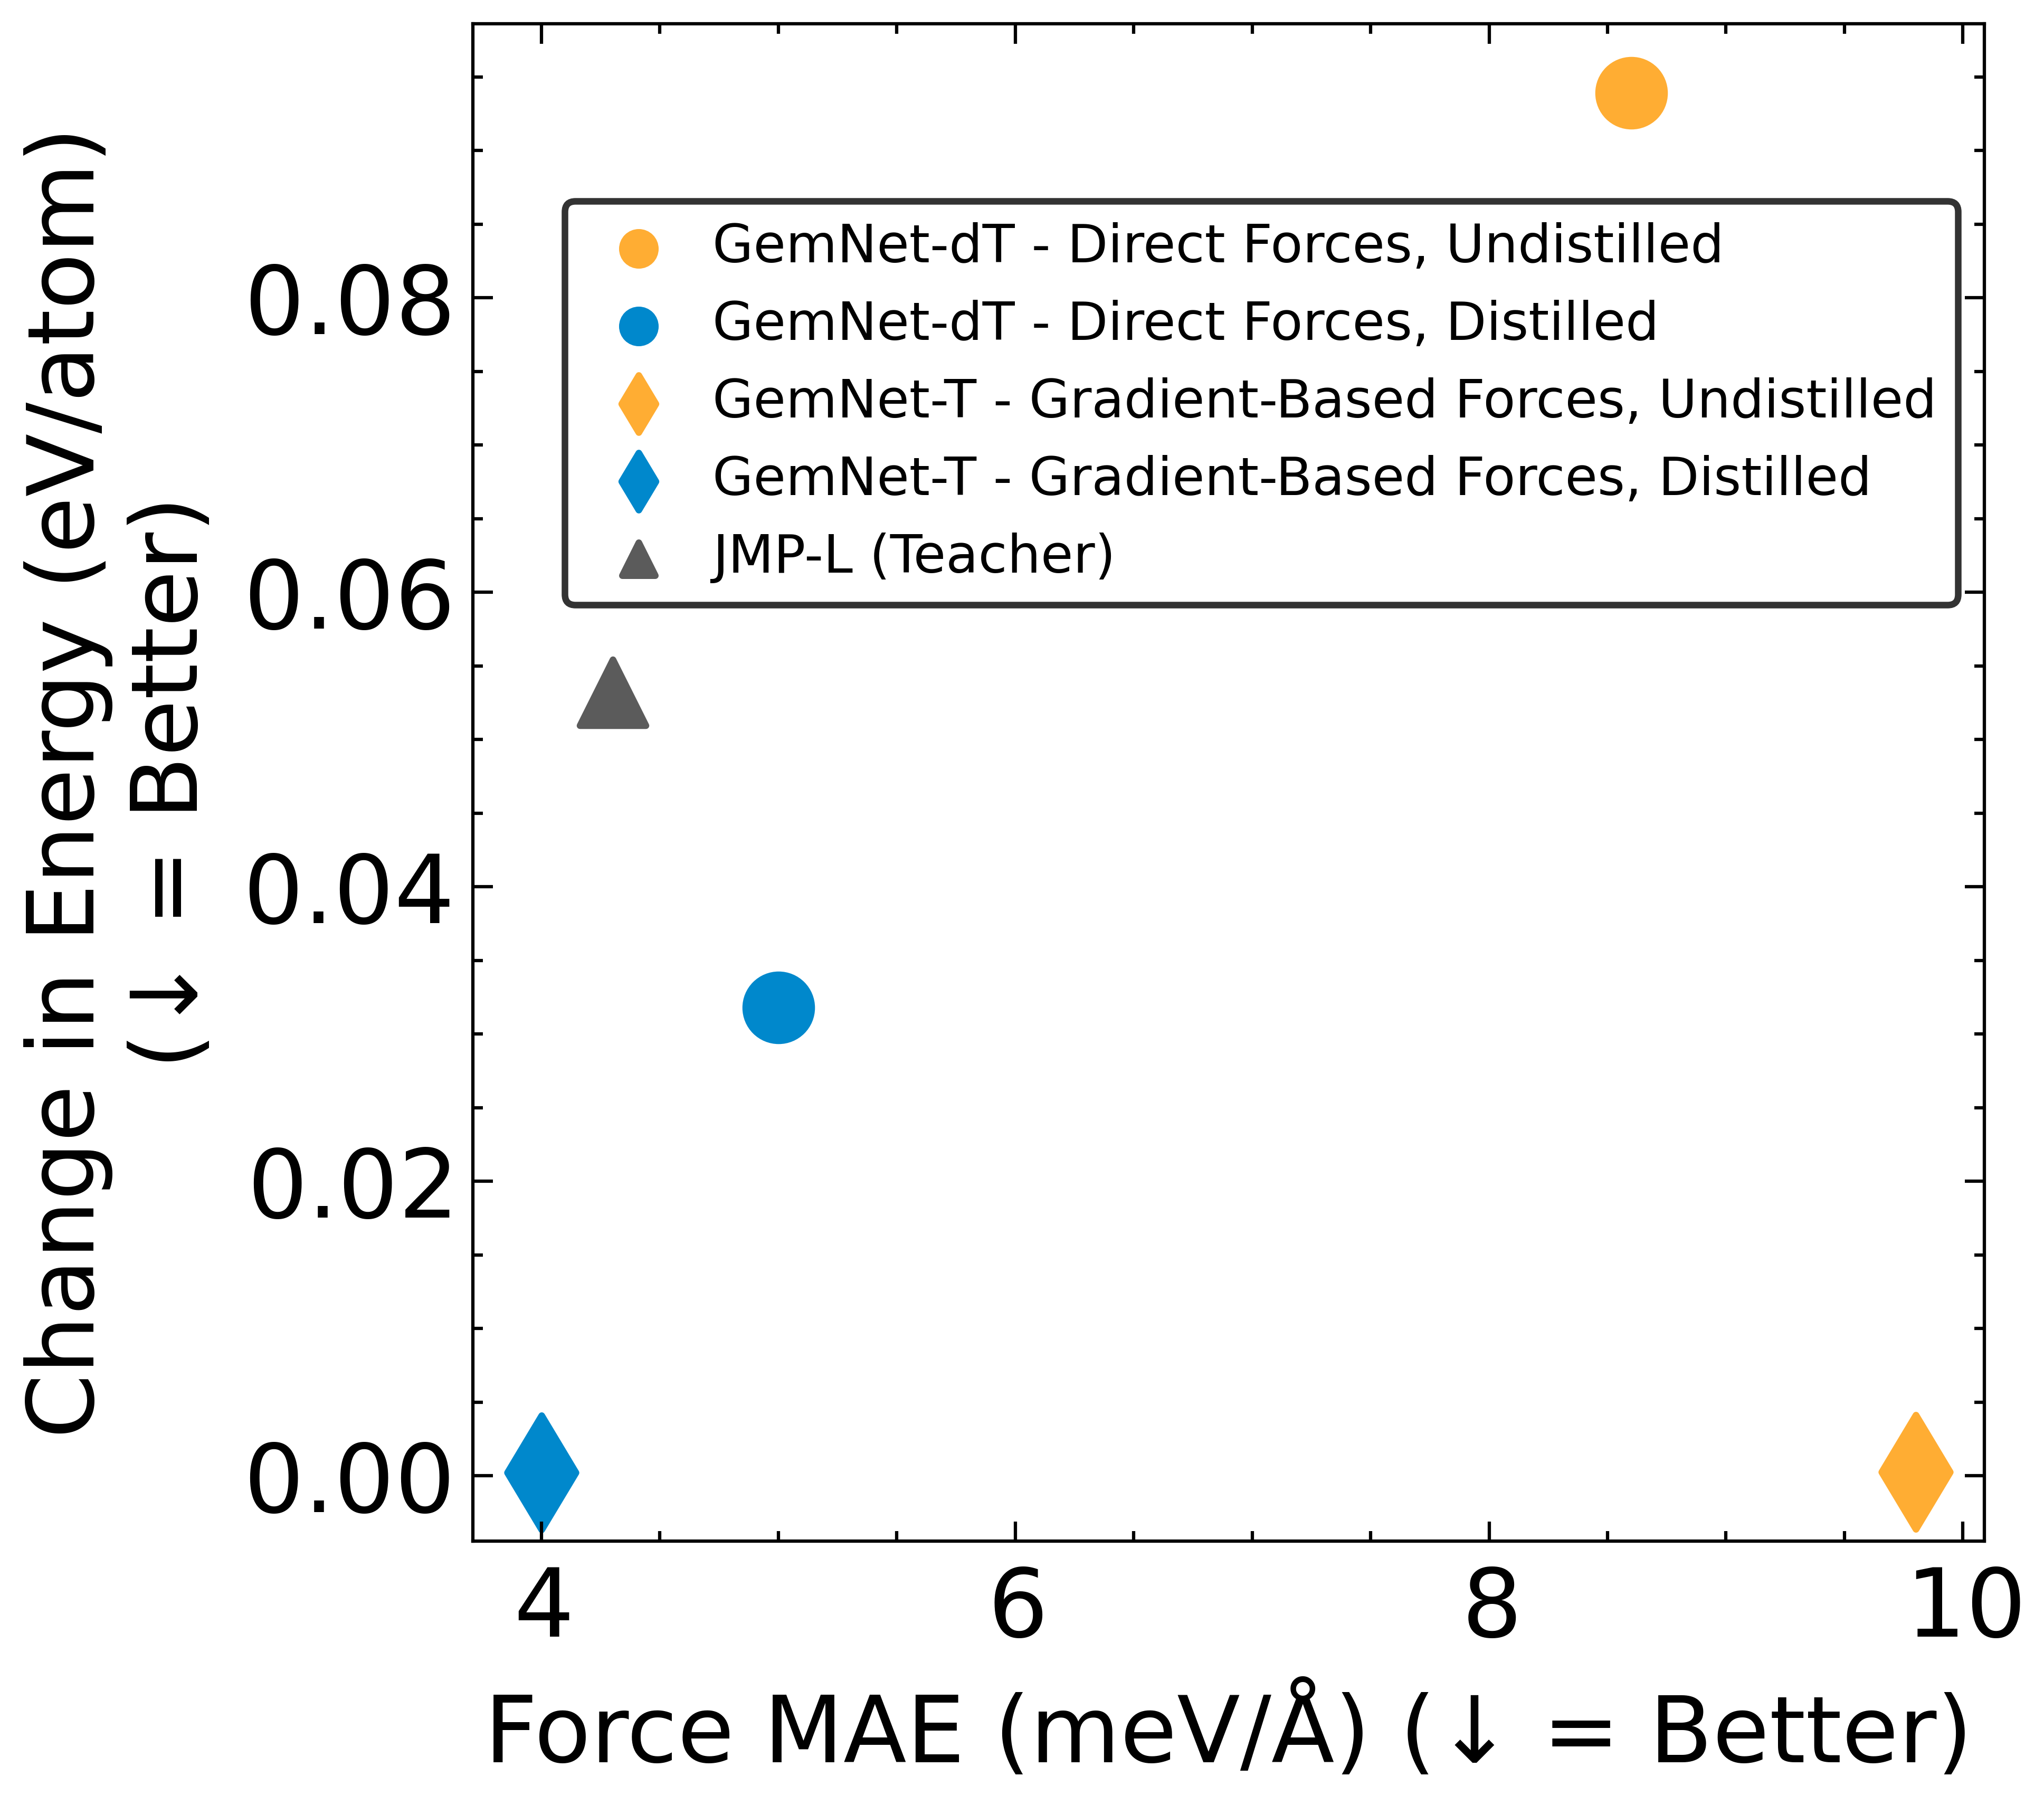

In [11]:
gemnet_dt_undistilled_force_mae = 8.6
gemnet_dt_distilled_force_mae = 5.0
gemnet_t_undistilled_force_mae = 9.8
gemnet_t_distilled_force_mae = 4.0

gemnet_dt_undistilled_energy_changes = [0.07100000000005148, 0.08770000000006585, 0.11250000000009332, 0.07349999999999236, 0.12489999999993652]
gemnet_dt_distilled_energy_changes = [0.002300000000016189, 0.03900000000001237, 0.03810000000001092, 0.03619999999991942, 0.04340000000004475]
gemnet_t_undistilled_energy_changes = [0.0003000000000634827, 0.0003000000000634827, 0.0001, 0.00040000000003838067, 0.00019999999997489794]
gemnet_t_distilled_energy_changes = [0.0001, 0.00019999999997489794, 0.00040000000003838067, 0.0003000000000634827, 0.00019999999997489794]

jmp_l_force_mae = 4.3
jmp_l_energy_changes = [0.05080000000000619, 0.06409999999996453, 0.03379999999995344, 0.08220000000008222, 0.03499999999999327]

plt.figure(figsize=(4.5, 4))
plt.scatter(gemnet_dt_undistilled_force_mae, np.mean(gemnet_dt_undistilled_energy_changes), 
            label="GemNet-dT - Direct Forces, Undistilled", color=ORANGE, s=100, marker='o')
plt.scatter(gemnet_dt_distilled_force_mae, np.mean(gemnet_dt_distilled_energy_changes), 
            label="GemNet-dT - Direct Forces, Distilled", color=RBLUE, s=100, marker='o')
plt.scatter(gemnet_t_undistilled_force_mae, np.mean(gemnet_t_undistilled_energy_changes), 
            label="GemNet-T - Gradient-Based Forces, Undistilled", color=ORANGE, s=150, marker='d')  # Use diamond marker for visibility
plt.scatter(gemnet_t_distilled_force_mae, np.mean(gemnet_t_distilled_energy_changes), 
            label="GemNet-T - Gradient-Based Forces, Distilled", color=RBLUE, s=150, marker='d')  # Use diamond marker for visibility
plt.scatter(jmp_l_force_mae, np.mean(jmp_l_energy_changes), 
            label="JMP-L (Teacher)", color=DARK_GRAY, s=100, marker='^')  # Use upward triangle

# Add labels and annotations
plt.xlabel("Force MAE (meV/Å) (↓ = Better)", fontsize=14)
plt.ylabel("Change in Energy (eV/atom)\n(↓ = Better)", fontsize=14)
plt.legend(loc='center right', bbox_to_anchor = (1, 0.75), frameon=True, edgecolor='black', fontsize=8, handletextpad=0.4, markerscale=0.5)

# Save the plot
plt.tight_layout()

plt.savefig("force_vs_energy.png")

